In [33]:
#for pandas
import pandas as pd

In [34]:
#for numpy
import numpy as np

In [35]:
#for visualization purpose
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
import missingno as msno

In [37]:
#for random forest from scikit learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import LabelEncoder

In [38]:
def impute_other(data,yo1,yo2,survstats,deadstats,yos,yoc,yoq,fare_avg,istest=False):
    if istest==True:
        minus=1
    else:
        minus=0
    #first processing Age column
    nullind=data["Age"].index[data["Age"].apply(np.isnan)]
    for i in nullind:
      if data.iloc[i,1]==1:
        data.iloc[i,5-minus]=float(yo1)
      else:
        data.iloc[i,5-minus]=float(yo2)
    
    #now dealing with sex column
    #as it has no null values so we just replace male by 0 and female by 1
    data.iloc[(data["Sex"]=="male").ravel(),4-minus]=0
    data.iloc[(data["Sex"]=="female").ravel(),4-minus]=1
    
    #now dealing with Embarked column
    #now we deal with null values and then we just replace by 0,1,-1
    #checking for null values
    if istest==False:
      captain=['S','C','Q']
      check=data["Embarked"].isnull().sum()
      if check!=0:
        miss=pd.isna(data["Embarked"])
        for i in range(0,len(miss)):
          if ((miss[i]==True)&(data.iloc[i,1]==1)):
             data.iloc[i,11]=captain[np.argmax(survstats)]
          elif ((miss[i]==True)&(data.iloc[i,1]==0)):
             data.iloc[i,11]=captain[np.argmax(deadstats)]
      
    data.iloc[(data["Embarked"]=="C").ravel(),11-minus]=float(yoc)
    data.iloc[(data["Embarked"]=="Q").ravel(),11-minus]=float(yoq)
    data.iloc[(data["Embarked"]=="S").ravel(),11-minus]=float(yos)
    
    #dealing with missing fare in test set
    check=data["Fare"].isnull().sum()
    if check!=0:
        miss=data["Fare"].index[data["Fare"].apply(np.isnan)]
        for i in miss:
            data.iloc[i,9-minus]=fare_avg
    
    #converting columns to float
    if istest==False:
      data["Survived"]=data["Survived"].astype(float)
    
    data["Pclass"]=data["Pclass"].astype(float)
    data["Sex"]=data["Sex"].astype(float)
    data["Age"]=data["Age"].astype(float)
    data["SibSp"]=data["SibSp"].astype(float)
    data["Parch"]=data["Parch"].astype(float)
    data["Fare"]=data["Fare"].astype(float)
    data["Embarked"]=data["Embarked"].astype(float)

    
    return data

In [39]:
def impute_own(data):
    #first processing Age column
    surv=((data["Survived"]==1)&(data["Age"].notnull())).ravel()
    dead=((data["Survived"]==0)&(data["Age"].notnull())).ravel()
    hey=np.array(data.iloc[surv,5])
    heyo=np.array(data.iloc[dead,5])
    plt.subplot(1,2,1)
    ax1=sns.distplot(hey,bins=25)
    plt.subplot(1,2,2)
    ax2=sns.distplot(heyo,bins=25)
    x1,y1=ax1.lines[0].get_data()
    x2,y2=ax2.lines[0].get_data()
    yo1=x1[np.argmax(y1)]
    yo2=x2[np.argmax(y2)]
    if data["Age"].isnull().sum()!=0:
      nullind=data["Age"].index[data["Age"].apply(np.isnan)]
      for i in nullind:
        if data.iloc[i,1]==1:
          data.iloc[i,5]=float(yo1)
        else:
          data.iloc[i,5]=float(yo2)
    
    #now dealing with sex column
    #as it has no null values so we just replace male by 0 and female by 1
    data.iloc[(data["Sex"]=="male").ravel(),4]=0
    data.iloc[(data["Sex"]=="female").ravel(),4]=1
    
    #now dealing with Embarked column
    #now we deal with null values and then we just replace by 0,1,-1
    #checking for null values
    surv=data.iloc[((data["Survived"]==1)&(data["Embarked"].notnull())).ravel(),11]
    heys=surv.value_counts()
    dead=data.iloc[((data["Survived"]==0)&(data["Embarked"].notnull())).ravel(),11]
    heyd=dead.value_counts()
    ss=heys["S"]
    cs=heys["C"]
    qs=heys["Q"]
    sd=heyd["S"]
    cd=heyd["C"]
    qd=heyd["Q"]
    survstats=[ss,cs,qs]
    deadstats=[sd,cd,qd]
    captain=['S','C','Q']
    yos=ss/(ss+sd)
    yoc=cs/(cs+cd)
    yoq=qs/(qs+qd)
    check=data["Embarked"].isnull().sum()
    if check!=0:
      miss=pd.isna(data["Embarked"])
      for i in range(0,len(miss)):
        if ((miss[i]==True)&(data.iloc[i,1]==1)):
           data.iloc[i,11]=captain[np.argmax(survstats)]
        elif ((miss[i]==True)&(data.iloc[i,1]==0)):
           data.iloc[i,11]=captain[np.argmax(deadstats)]
      
    data.iloc[(data["Embarked"]=="C").ravel(),11]=float(yoc)
    data.iloc[(data["Embarked"]=="Q").ravel(),11]=float(yoq)
    data.iloc[(data["Embarked"]=="S").ravel(),11]=float(yos)
    
    #dealing with missing fare in test set
    fare_avg=(1/data.shape[0])*(data["Fare"].sum())
    
    #converting columns to float
    data["Survived"]=data["Survived"].astype(float)
    data["Pclass"]=data["Pclass"].astype(float)
    data["Sex"]=data["Sex"].astype(float)
    data["Age"]=data["Age"].astype(float)
    data["SibSp"]=data["SibSp"].astype(float)
    data["Parch"]=data["Parch"].astype(float)
    data["Fare"]=data["Fare"].astype(float)
    data["Embarked"]=data["Embarked"].astype(float)

    
    return data,yo1,yo2,survstats,deadstats,yos,yoc,yoq,fare_avg

In [40]:
def output_test(rf,x,filename):
    y=np.array(rf.predict(x)).reshape(-1,1)
    hey=np.arange(892,1310,1).reshape(-1,1)
    filename=filename+".csv"
    hey=np.hstack((hey,y))
    np.savetxt(filename,hey,header="PassengerId,Survived",delimiter=',')

In [41]:
dfl="C:/Users/Ritik/Desktop/Projects_Flash/Titanic_/train.csv"

In [42]:
datatrain=pd.read_csv(dfl,header=0)

In [43]:
dfl="C:/Users/Ritik/Desktop/Projects_Flash/Titanic_/test.csv"

In [44]:
datatest=pd.read_csv(dfl,header=0)

['Age', 'Cabin', 'Embarked']


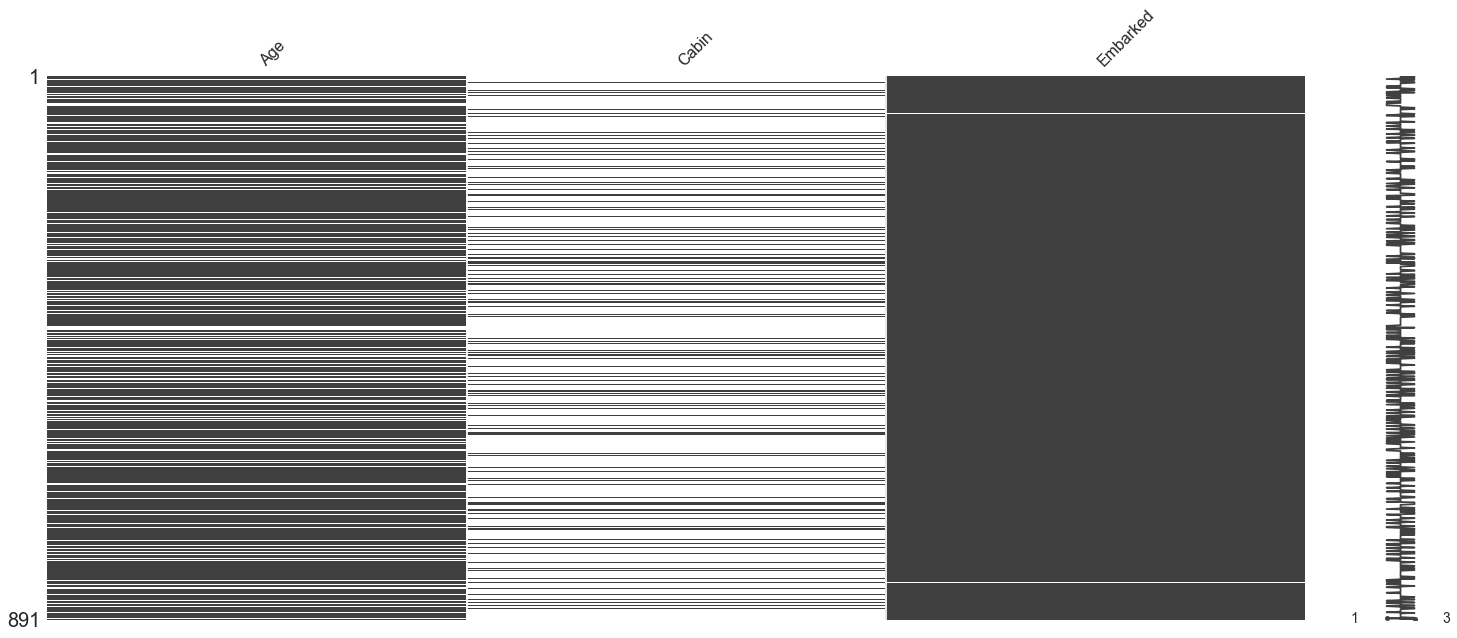

In [45]:
col_with_miss=datatrain.columns[datatrain.isnull().any()].tolist()
print(col_with_miss)
msno.matrix(datatrain[col_with_miss])

['Age', 'Fare', 'Cabin']


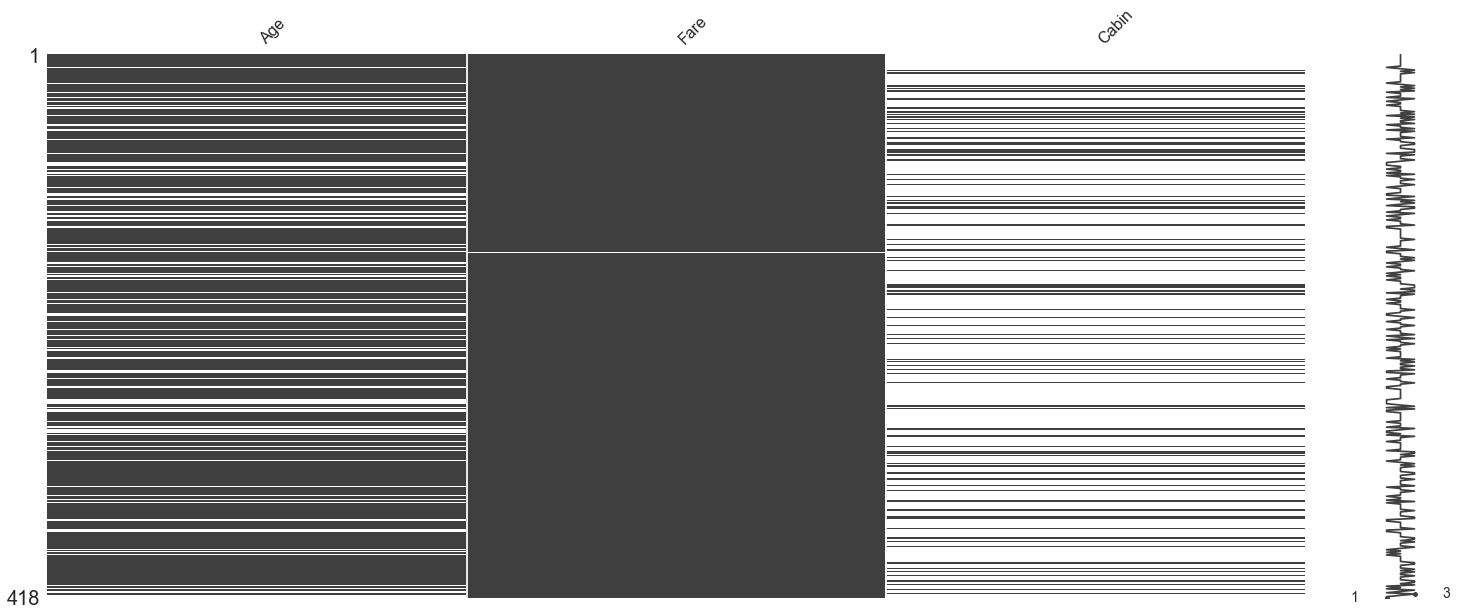

In [46]:
col_with_miss=datatest.columns[datatest.isnull().any()].tolist()
print(col_with_miss)
msno.matrix(datatest[col_with_miss])

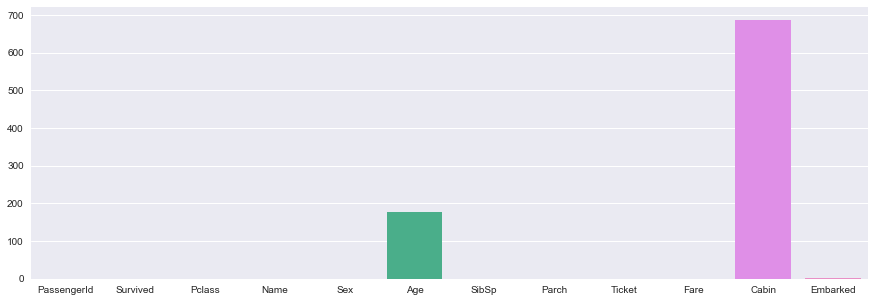

In [47]:
colnames=datatrain.columns.values
misscount=[datatrain[x].isnull().sum() for x in colnames]
sns.set()
plt.figure(figsize=(15,5))
sns.barplot(colnames,misscount)

In [48]:
datatrain.isnull().sum(axis=0)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

<Container object of 11 artists>

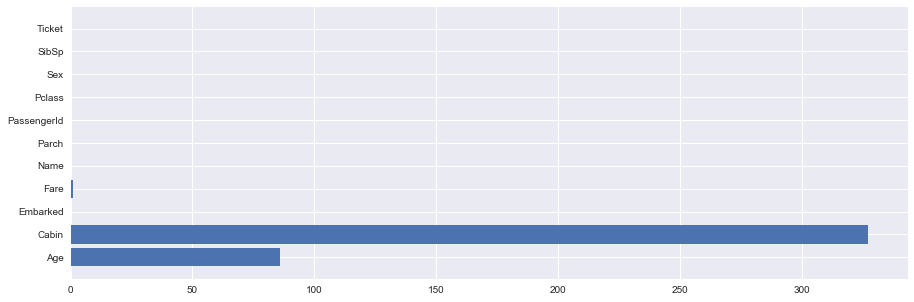

In [49]:
plt.figure(figsize=(15,5))
plt.barh(datatest.columns.values,datatest.isnull().sum())

In [50]:
datatest.isnull().sum(axis=0)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [51]:
colnames=datatrain.columns.values
for i in range(0,len(colnames)):
    print("%d   %s"%(i,colnames[i]))

0   PassengerId
1   Survived
2   Pclass
3   Name
4   Sex
5   Age
6   SibSp
7   Parch
8   Ticket
9   Fare
10   Cabin
11   Embarked


In [52]:
colnames=datatest.columns.values
for i in range(0,len(colnames)):
    print("%d   %s"%(i,colnames[i]))

0   PassengerId
1   Pclass
2   Name
3   Sex
4   Age
5   SibSp
6   Parch
7   Ticket
8   Fare
9   Cabin
10   Embarked


So,

- Age column has 177 null values
- Cabin has 687 null values
- Embarked has 2 null values
- Convert Embarked column to some numeric type
- Convert Sex column to some numeric type
- Convert every nueric column in use to float type

In [53]:
listy=[2,4,5,6,7,9,11]
listu=np.array(listy)-1

Here we will use Random Forest Model

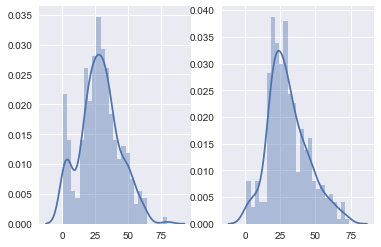

In [54]:
datatrain_new,yo1,yo2,survstats,deadstats,yos,yoc,yoq,fare_avg=impute_own(datatrain)

In [55]:
datatest_new=impute_other(datatest,yo1,yo2,survstats,deadstats,yos,yoc,yoq,fare_avg,True)

In [57]:
datatrain_new.dtypes

PassengerId      int64
Survived       float64
Pclass         float64
Name            object
Sex            float64
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked       float64
dtype: object

In [58]:
datatest_new.dtypes

PassengerId      int64
Pclass         float64
Name            object
Sex            float64
Age            float64
SibSp          float64
Parch          float64
Ticket          object
Fare           float64
Cabin           object
Embarked       float64
dtype: object

In [24]:
xtrain=np.array(datatrain_new.iloc[:,listy])
ytrain=np.array(datatrain_new.iloc[:,1]).reshape(-1,1)
xtest=np.array(datatest_new.iloc[:,listu])

Now implementing Random Forest model

First we will use RandomizedSearchCV

In [25]:
rf=RandomForestClassifier()
rf.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [26]:
params_try={"n_estimators":[int(i) for i in np.linspace(10,200,30)],  
            "max_depth":[int(i) for i in np.linspace(10, 110,30)], 
            "min_samples_split":[2,5,10,15,20,25,30], 
            "min_samples_leaf":[int(i) for i in np.linspace(1,50,30)], 
            "max_features":['auto','sqrt'],  
            "bootstrap":[True,False],   
            }

In [27]:
random_search=RandomizedSearchCV(rf,param_distributions=params_try,n_iter=700,cv=5,verbose=2,random_state=91,n_jobs=-1)
random_search=random_search.fit(xtrain,ytrain.ravel())

Fitting 5 folds for each of 700 candidates, totalling 3500 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   38.9s
[Parallel(n_jobs=-1)]: Done 658 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1023 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1468 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1995 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2602 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 3291 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-1)]: Done 3500 out of 3500 | elapsed: 13.9min finished


In [59]:
best_random_params=random_search.best_params_
print(best_random_params)

{'n_estimators': 16, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 27, 'bootstrap': True}


In [29]:
#features selected by random estimation
ran_n_estimators=best_random_params["n_estimators"]
ran_min_samples_split=best_random_params["min_samples_split"]
ran_min_samples_leaf=best_random_params["min_samples_leaf"]
ran_max_features=best_random_params["max_features"]
ran_max_depth=best_random_params["max_depth"]
ran_bootstrap=best_random_params["bootstrap"]

In [30]:
rf=RandomForestClassifier()
print(rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [66]:
params_try={"n_estimators":[int(i) for i in np.linspace(ran_n_estimators-10,ran_n_estimators+20,30)],  
            "max_depth":[int(i) for i in np.linspace(ran_max_depth-10,ran_max_depth+10,20)], 
            "min_samples_split":[int(i) for i in np.linspace(ran_min_samples_split,ran_min_samples_split+10,5)], 
            "min_samples_leaf":[int(i) for i in np.linspace(ran_min_samples_leaf,ran_min_samples_leaf+20,10)], 
            "max_features":[ran_max_features],
            "bootstrap":[ran_bootstrap]   
            }

In [67]:
grid_search=GridSearchCV(rf,param_grid=params_try,cv=3,n_jobs=-1,verbose = 2)
grid_search.fit(xtrain,ytrain.ravel())

Fitting 3 folds for each of 30000 candidates, totalling 90000 fits


[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 698 tasks      | elapsed:   16.0s
[Parallel(n_jobs=-1)]: Done 1830 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 3290 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 5070 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 7178 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 8592 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 9970 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 11508 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 13210 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 15072 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 17098 tasks      | elapsed: 11.5min
[Parallel(n_jobs=-1)]: Done 19284 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 21634 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 24144 tasks      | elaps

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36], 'max_depth': [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37], 'min_samples_split': [2, 4, 7, 9, 12], 'min_samples_leaf': [2, 4, 6, 8, 10, 13, 15, 17, 19, 22], 'max_features': ['sqrt'], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scori

In [68]:
grid_best_params=grid_search.best_params_
print(grid_best_params)
best_rf_grid=grid_search.best_estimator_

{'bootstrap': True, 'max_depth': 31, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 16}


In [69]:
output_test(best_rf_grid,xtest,"RF_stats_submission_two")